# Step 0. Install dependencies

In [1]:
#Install dependencies
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets
!pip install torchinfo

# Step 1. EDA

In [2]:
#Import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset

In [3]:
financial_news = pd.read_csv('all-data.csv', encoding='latin', header=None) #read csv set header to none because columns have no title
financial_news.rename(columns={0: 'label', 1:'news'}, inplace=True) #rename columns

In [4]:
#Check DF head and Tail
financial_news.head()
financial_news.tail()

,label,news
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...
4845,negative,Sales in Finland decreased by 10.5 % in Januar...


In [5]:
#Check shape of train df
financial_news.shape

(4846, 2)

In [6]:
#Check information of df
#we can see there is no missing values
financial_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   news    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


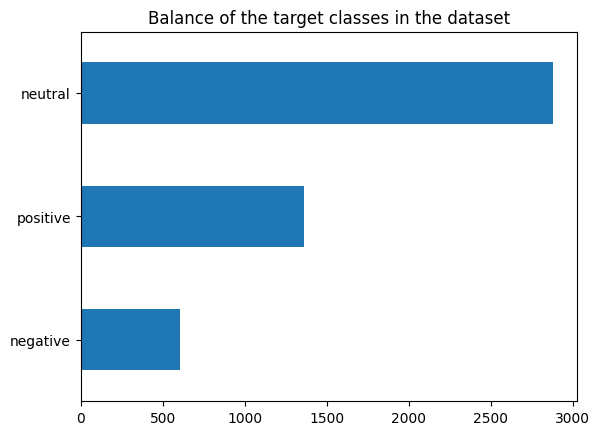

neutral     2879
positive    1363
negative     604
Name: label, dtype: int64


In [7]:
#Check balance of the data set
financial_news['label'].value_counts(ascending=True).plot.barh()
plt.title("Balance of the target classes in the dataset")
plt.show()

#We can notice that the data set is imbalanced
print(financial_news['label'].value_counts())

In [8]:
#Check the maximum lenght of the documents
financial_news['len'] = financial_news['news'].apply(lambda text: len(text.split()))
print(financial_news['len'].max())

financial_news.drop(columns={'len'}, inplace=True)

81

# Step 2. Pre-processing

### Approach 1. do not balance classes

In [10]:
#First let's map the labels to integers

lable_map = {'negative': 2, 'neutral': 0, 'positive': 1}
financial_news['label'] = financial_news['label'].map(lable_map)
financial_news.head()

,label,news
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...


In [11]:
#Save approach 1 dataframe to folder
financial_news.to_csv('financial_news_1.csv', index=False)

### Approach 2. Downsampling

In [12]:
# Let's downsample positive and neutral labels to create a balanced data set
financial_news_ds = financial_news.copy() # Copy DF

#Now let's separate our 3 classes to perform downsample
financial_news_n = financial_news_ds.loc[financial_news_ds.label == 2] #Negative label
financial_news_0 = financial_news_ds.loc[financial_news_ds.label ==  0] #Neutral label
financial_news_1 = financial_news_ds.loc[financial_news_ds.label ==  1] #Positive label

In [13]:
#Check separated labels
financial_news_n['label'].unique()
financial_news_0['label'].unique()
financial_news_1['label'].unique()

array([1])

In [14]:
#Downsample positive and neutral labels to be same length as negative label
financial_news_0 = financial_news_0.iloc[0:604, :]
financial_news_1 = financial_news_1.iloc[0:604, :]

In [15]:
#Check shapes
financial_news_0['label'].shape
financial_news_1['label'].shape

(604,)

In [16]:
#put everything together again
financial_news_ds = pd.concat([financial_news_n, financial_news_0, financial_news_1])

#shuffle rows and reset index
financial_news_ds = financial_news_ds.sample(frac=1).reset_index(drop=True)

#check df
#financial_news_ds.tail()

,label,news
1807,2,Vaisala 's net profit for the third quarter of...
1808,1,Revenue grew by 2 percent to x20ac 580 millio...
1809,0,A. Le Coq Special was developed for the bicent...
1810,2,The current reference grade instruments are ch...
1811,0,The report profiles 614 companies including ma...


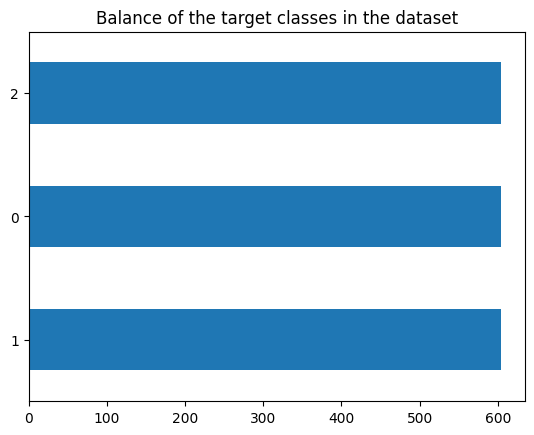

1    604
0    604
2    604
Name: label, dtype: int64


In [17]:
#Check balance of the data set
financial_news_ds['label'].value_counts(ascending=True).plot.barh()
plt.title("Balance of the target classes in the dataset")
plt.show()

#We can notice that the data set is now balanced
print(financial_news_ds['label'].value_counts())

In [18]:
#save approach 2 dataframe
financial_news_ds.to_csv('financial_news_2.csv', index=False)

# Step 3. Feature extraction

## Feature Extraction for Transfer Learning

In [19]:
# Load raw data set
from datasets import load_dataset
from datasets import DatasetDict
raw_dataset_1 = load_dataset('csv', data_files='financial_news_1.csv')
raw_dataset_2 = load_dataset('csv', data_files='financial_news_2.csv')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
#Check raw data sets
raw_dataset_1
raw_dataset_2

DatasetDict({
    train: Dataset({
        features: ['label', 'news'],
        num_rows: 1812
    })
})

In [21]:
#Create train, test and validation splits

#First split into train/test 30% for split, and specify seed
train_test_split_1 = raw_dataset_1['train'].train_test_split(test_size=0.2, seed=18)
train_test_split_2 = raw_dataset_2['train'].train_test_split(test_size=0.2, seed=18)

#Now split into train/test/val making 40% of test data for validation and specify seed
train_test_val_split_1 = train_test_split_1['test'].train_test_split(test_size=0.4, seed=18)
train_test_val_split_2 = train_test_split_2['test'].train_test_split(test_size=0.4, seed=18)

#Gather everything into single dataset dicts
train_test_val_split_1 = DatasetDict({'train': train_test_split_1['train'], 'test': train_test_val_split_1['train'], 'valid': train_test_val_split_1['test']})
train_test_val_split_2 = DatasetDict({'train': train_test_split_2['train'], 'test': train_test_val_split_2['train'], 'valid': train_test_val_split_2['test']})

train_test_val_split_1

DatasetDict({
    train: Dataset({
        features: ['label', 'news'],
        num_rows: 3876
    })
    test: Dataset({
        features: ['label', 'news'],
        num_rows: 582
    })
    valid: Dataset({
        features: ['label', 'news'],
        num_rows: 388
    })
})

In [22]:
# For fine tuning a pre trained model we are choosing to use distilBERT since it's lighter than other BERT based models while conserving the vast majority of BERT's performance

# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [23]:
#Define function to tokenize data in a batch which should be a dictionary like object containing data to be tokenized
def to_tokens(batch):
    return tokenizer(batch['news'], truncation=True, padding=True)

In [24]:
#Now tokenize data from the data sets:
tokenized_split_1 = train_test_val_split_1.map(to_tokens, batched=True)
tokenized_split_2 = train_test_val_split_2.map(to_tokens, batched=True)

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/1449 [00:00<?, ? examples/s]

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

In [25]:
#Check dataset
tokenized_split_1

DatasetDict({
    train: Dataset({
        features: ['label', 'news', 'input_ids', 'attention_mask'],
        num_rows: 3876
    })
    test: Dataset({
        features: ['label', 'news', 'input_ids', 'attention_mask'],
        num_rows: 582
    })
    valid: Dataset({
        features: ['label', 'news', 'input_ids', 'attention_mask'],
        num_rows: 388
    })
})

## Feature Extraction for Training an LSTM model from scratch
### Ignore this section in this notebook

In [ ]:
#For this approach we will use Word2Vec Google negative 300 bin file.
#Since this file was trained on news it should make sense to make feature extraction for news headlines
#import libraries
from gensim.models import Word2Vec, KeyedVectors

#Read bin file
#Word2Vec
data_path = 'data/GoogleNews-vectors-negative300.bin'

#load Word2Vec Model
word2vec_model = KeyedVectors.load_word2vec_format(data_path, binary=True)

In [ ]:
#Read data sets
w2v_dataset_1 = pd.read_csv('data/financial_news_1.csv')
w2v_dataset_2 = pd.read_csv('data/financial_news_2.csv')

w2v_dataset_1.head()
w2v_dataset_2.head()

In [ ]:
#Get a list of list of the news cleaned from non alphabet characters
list_of_list_news_1 = [w2v_dataset_1.loc[i, ['news']].iloc[0].split() for i in range(len(w2v_dataset_1['news']))]
list_of_list_news_2 = [w2v_dataset_2.loc[i, ['news']].iloc[0].split() for i in range(len(w2v_dataset_2['news']))]

In [ ]:
list_of_list_news_1[0]

In [ ]:
#Clean each new from non alphabet characters
import re
regex = re.compile('[^a-zA-Z]')

re_list_of_lists_1 = []
for i in range(len(list_of_list_news_1)):
    temp = [regex.sub('', list_of_list_news_1[i][token]) for token in range(len(list_of_list_news_1[i]))]
    temp = list(filter(lambda a: a != '', temp))
    re_list_of_lists_1.append(temp)

re_list_of_lists_2 = []
for i in range(len(list_of_list_news_2)):
    temp = [regex.sub('', list_of_list_news_2[i][token]) for token in range(len(list_of_list_news_2[i]))]
    temp = list(filter(lambda a: a != '', temp))
    re_list_of_lists_2.append(temp)

In [ ]:
re_list_of_lists_1[0]

In [ ]:
#Extract Features using Word2Vec
def embbeding_word_feats(list_of_lists):
    #DIMENSION = 300 #Dimension of the vectors that represent word (embbedings)
    #zero_vector = np.zeros(DIMENSION) #zero vector
    feats = []
    corpus = list_of_lists
    for doc in corpus:
        feats_for_doc = []
        for token in doc:
            if token in word2vec_model:
                feats_for_doc.append(word2vec_model[token])
        feats.append(feats_for_doc)
    return feats

In [ ]:
w2v_embbedings_1 = embbeding_word_feats(re_list_of_lists_1)
w2v_embbedings_2 = embbeding_word_feats(re_list_of_lists_2)

In [ ]:
#Sanity checkk
print(w2v_dataset_1.shape)
print(len(w2v_embbedings_1))
print(len(w2v_embbedings_1[0]))
print(len(w2v_embbedings_1[0][1]))

In [ ]:
#Right the number of tokens in each document is different so we need to padd them to be able to feed them to the LSTM nn

#Check the maximum number of tokens in documents across the corpus
temp_1 = [len(w2v_embbedings_1[i]) for i in range(len(w2v_embbedings_1))]
print(max(temp_1))

temp_2 = [len(w2v_embbedings_2[i]) for i in range(len(w2v_embbedings_2))]
print(max(temp_2))

In [ ]:
#Pad the number of tokens in documents
def padding_embbedings(list_of_lists, pad_to=45):
    DIMENSION = 300 #Dimension of the vectors that represent word (embbedings)
    zero_vector = np.zeros(DIMENSION) #zero vector
    feats = []
    corpus = list_of_lists
    for doc in corpus:
        padded_doc = doc.copy()
        if len(doc) < pad_to:
            a = pad_to - len(doc)
            for i in range(a):
                padded_doc.append(zero_vector)
        feats.append(padded_doc)
    return feats


In [ ]:
w2v_embbedings_1 = padding_embbedings(w2v_embbedings_1, pad_to=45)
w2v_embbedings_2 = padding_embbedings(w2v_embbedings_2, pad_to=45)

In [ ]:
#Sanity checkk
print(w2v_dataset_2.shape)
print(len(w2v_embbedings_2))
print(len(w2v_embbedings_2[0]))
print(len(w2v_embbedings_2[0][1]))

In [ ]:
#Now cast to np array
X_1 = np.array(w2v_embbedings_1)
X_2 = np.array(w2v_embbedings_2)

y_1 = np.array(w2v_dataset_1['label'])
y_2 = np.array(w2v_dataset_2['label'])

#Finally let's do tran val test split
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=18)
X_test_1, X_val_1, y_test_1, y_val_1 = train_test_split(X_test_1, y_test_1, test_size=0.4, random_state=18)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=18)
X_test_2, X_val_2, y_test_2, y_val_2 = train_test_split(X_test_2, y_test_2, test_size=0.4, random_state=18)

In [ ]:
#Sanity check
X_train_1.shape

# Step 4. Training

### Approach 1. Fine Tune pre-trained distilBERT model

In [36]:
#import bert model
#AutomodelForSequenceClassification will give us a model that already has some classification layers on top of distilbert
#Trainer is a class that help us train transformers, TrainingArguments is used to define training arguments in Trainer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

#model_ckpt = 'distil-bert-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Define device
#One model to train only head and freeze bottom layers
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=3).to(device))
#One model fully trainable
model_2 = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=3).to(device))


In [37]:
# Confirm device
device

device(type='cuda')

In [ ]:
#See summary of model
from torchinfo import summary
summary(model)

In [ ]:
#Check trainable layers of the model
for name, param in model.named_parameters():
     print(name, param.requires_grad)

In [38]:
#Freeze all distilbert layers
for name, param in model.distilbert.named_parameters():
     param.requires_grad = False

In [ ]:
#Check again trainable and non trainable layers
#Check trainable layers of the model
for name, param in model.named_parameters():
     print(name, param.requires_grad)

In [39]:
#Compile model
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [40]:
#Define performance metrics
from sklearn.metrics import accuracy_score, f1_score
def score_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [41]:
#Train model

# model with frozen layers and imbalanced dataset
trainer_1 = Trainer(model,
                  training_args,
                  train_dataset = tokenized_split_1["train"],
                  eval_dataset = tokenized_split_1["valid"],
                  tokenizer=tokenizer,
                  compute_metrics=score_metrics)

# model with frozen layers and balanced dataset
trainer_2 = Trainer(model,
                  training_args,
                  train_dataset = tokenized_split_2["train"],
                  eval_dataset = tokenized_split_2["valid"],
                  tokenizer=tokenizer,
                  compute_metrics=score_metrics)

# full trainable model and imbalanced dataset
trainer_3 = Trainer(model_2,
                  training_args,
                  train_dataset = tokenized_split_1["train"],
                  eval_dataset = tokenized_split_1["valid"],
                  tokenizer=tokenizer,
                  compute_metrics=score_metrics)

# full trainable model and balanced dataset
trainer_4 = Trainer(model_2,
                  training_args,
                  train_dataset = tokenized_split_2["train"],
                  eval_dataset = tokenized_split_2["valid"],
                  tokenizer=tokenizer,
                  compute_metrics=score_metrics)

In [44]:
#Train model and measure time
# model with frozen layers and imbalanced dataset
import time
start = time.time()
trainer_1.train()
end = time.time()
print("Training execution time ",end-start, 2)

{'eval_loss': 0.6651861667633057, 'eval_accuracy': 0.6623711340206185, 'eval_f1': 0.615529138943091, 'eval_runtime': 1.1554, 'eval_samples_per_second': 335.827, 'eval_steps_per_second': 6.059, 'epoch': 1.0}
{'eval_loss': 0.638648271560669, 'eval_accuracy': 0.6701030927835051, 'eval_f1': 0.6323507685228298, 'eval_runtime': 1.1812, 'eval_samples_per_second': 328.487, 'eval_steps_per_second': 5.926, 'epoch': 2.0}
{'loss': 0.6525, 'learning_rate': 1.570644718792867e-05, 'epoch': 2.06}
{'eval_loss': 0.6311352849006653, 'eval_accuracy': 0.6804123711340206, 'eval_f1': 0.6476594540755333, 'eval_runtime': 1.1814, 'eval_samples_per_second': 328.419, 'eval_steps_per_second': 5.925, 'epoch': 3.0}
{'train_runtime': 56.8013, 'train_samples_per_second': 204.714, 'train_steps_per_second': 12.834, 'train_loss': 0.6411872937028463, 'epoch': 3.0}
Training execution time  -0.002344093999681718 2


In [45]:
#Train model and measure time
# model with frozen layers and balanced dataset
import time
start = time.time()
trainer_2.train()
end = time.time()
print("Training execution time ",end-start, 2)

{'eval_loss': 0.6035476326942444, 'eval_accuracy': 0.7602739726027398, 'eval_f1': 0.758096729239751, 'eval_runtime': 0.2869, 'eval_samples_per_second': 508.951, 'eval_steps_per_second': 10.458, 'epoch': 1.0}
{'eval_loss': 0.5849981307983398, 'eval_accuracy': 0.773972602739726, 'eval_f1': 0.7722528569447507, 'eval_runtime': 0.2861, 'eval_samples_per_second': 510.251, 'eval_steps_per_second': 10.485, 'epoch': 2.0}
{'eval_loss': 0.5825031995773315, 'eval_accuracy': 0.7671232876712328, 'eval_f1': 0.766734016146932, 'eval_runtime': 0.2856, 'eval_samples_per_second': 511.267, 'eval_steps_per_second': 10.505, 'epoch': 3.0}
{'train_runtime': 13.2643, 'train_samples_per_second': 327.721, 'train_steps_per_second': 20.582, 'train_loss': 0.6541617816184466, 'epoch': 3.0}
Training execution time  -0.001540173999956096 2


In [46]:
#Train model and measure time
# fully trainable model and imbalanced dataset
import time
start = time.time()
trainer_3.train()
end = time.time()
print("Training execution time ",end-start, 2)

{'eval_loss': 0.42063993215560913, 'eval_accuracy': 0.8195876288659794, 'eval_f1': 0.822524545317873, 'eval_runtime': 1.17, 'eval_samples_per_second': 331.627, 'eval_steps_per_second': 5.983, 'epoch': 1.0}
{'eval_loss': 0.4005722999572754, 'eval_accuracy': 0.8350515463917526, 'eval_f1': 0.8361486368160397, 'eval_runtime': 1.1614, 'eval_samples_per_second': 334.078, 'eval_steps_per_second': 6.027, 'epoch': 2.0}
{'loss': 0.384, 'learning_rate': 1.570644718792867e-05, 'epoch': 2.06}
{'eval_loss': 0.5161873698234558, 'eval_accuracy': 0.8298969072164949, 'eval_f1': 0.8309416387147296, 'eval_runtime': 1.1694, 'eval_samples_per_second': 331.796, 'eval_steps_per_second': 5.986, 'epoch': 3.0}
{'train_runtime': 162.2176, 'train_samples_per_second': 71.681, 'train_steps_per_second': 4.494, 'train_loss': 0.29950033588173947, 'epoch': 3.0}
Training execution time  -0.003429329000027792 2


In [47]:
#Train model and measure time
# fully trainable model and balanced dataset
import time
start = time.time()
trainer_4.train()
end = time.time()
print("Training execution time ",end-start, 2)

{'eval_loss': 0.16250543296337128, 'eval_accuracy': 0.952054794520548, 'eval_f1': 0.9523733585428641, 'eval_runtime': 0.3, 'eval_samples_per_second': 486.695, 'eval_steps_per_second': 10.001, 'epoch': 1.0}
{'eval_loss': 0.18538278341293335, 'eval_accuracy': 0.9657534246575342, 'eval_f1': 0.9657513699050086, 'eval_runtime': 0.3097, 'eval_samples_per_second': 471.449, 'eval_steps_per_second': 9.687, 'epoch': 2.0}
{'eval_loss': 0.18359039723873138, 'eval_accuracy': 0.9726027397260274, 'eval_f1': 0.9726186240374108, 'eval_runtime': 0.3017, 'eval_samples_per_second': 483.959, 'eval_steps_per_second': 9.944, 'epoch': 3.0}
{'train_runtime': 41.3616, 'train_samples_per_second': 105.097, 'train_steps_per_second': 6.6, 'train_loss': 0.09551458393697773, 'epoch': 3.0}
Training execution time  42.25369381904602 2


# Step 5. Evaluate

In [49]:
#Taking a look at the information we can notice trainer_4 has the best performance let's evaluate it using the test data
preds_output = trainer_4.predict(tokenized_split_2["test"])

In [51]:
preds_output.metrics #Check output metrics of evaluation

{'test_loss': 0.2169266790151596,
 'test_accuracy': 0.9447004608294931,
 'test_f1': 0.9443401424854553,
 'test_runtime': 0.4778,
 'test_samples_per_second': 454.211,
 'test_steps_per_second': 8.373}

In [52]:
#Get the predictions
y_preds = np.argmax(preds_output.predictions, axis=1)

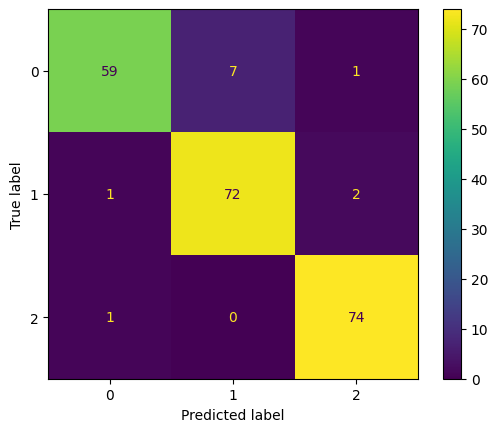

In [60]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(tokenized_split_2['test']['label'], y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#check evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


print("Accuracy :",round(accuracy_score(tokenized_split_2['test']['label'], y_preds), 2))
print("F1 Score :",round(f1_score(tokenized_split_2['test']['label'], y_preds, average=None), 2))